In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date
import seaborn as sns
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# To ignore all warnings:
warnings.filterwarnings("ignore")

In [51]:
ten_years_back = date.today().replace(year=date.today().year - 10)
start = ten_years_back
end = date.today().strftime("%Y-%m-%d")

In [52]:
df = yf.download('ADANIPORTS.NS', start, end)
df = df.reset_index()
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-08-21,294.399994,301.350006,293.350006,296.899994,281.747070,6936813
1,2014-08-22,296.950012,300.399994,294.250000,297.700012,282.506226,4107903
2,2014-08-25,297.299988,301.000000,291.700012,293.350006,278.378204,2557796
3,2014-08-26,292.500000,300.899994,289.250000,298.000000,282.790863,2768112
4,2014-08-27,299.250000,302.700012,284.299988,288.250000,273.538544,3607703


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462 entries, 0 to 2461
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2462 non-null   datetime64[ns]
 1   Open       2462 non-null   float64       
 2   High       2462 non-null   float64       
 3   Low        2462 non-null   float64       
 4   Close      2462 non-null   float64       
 5   Adj Close  2462 non-null   float64       
 6   Volume     2462 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 134.8 KB


In [54]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

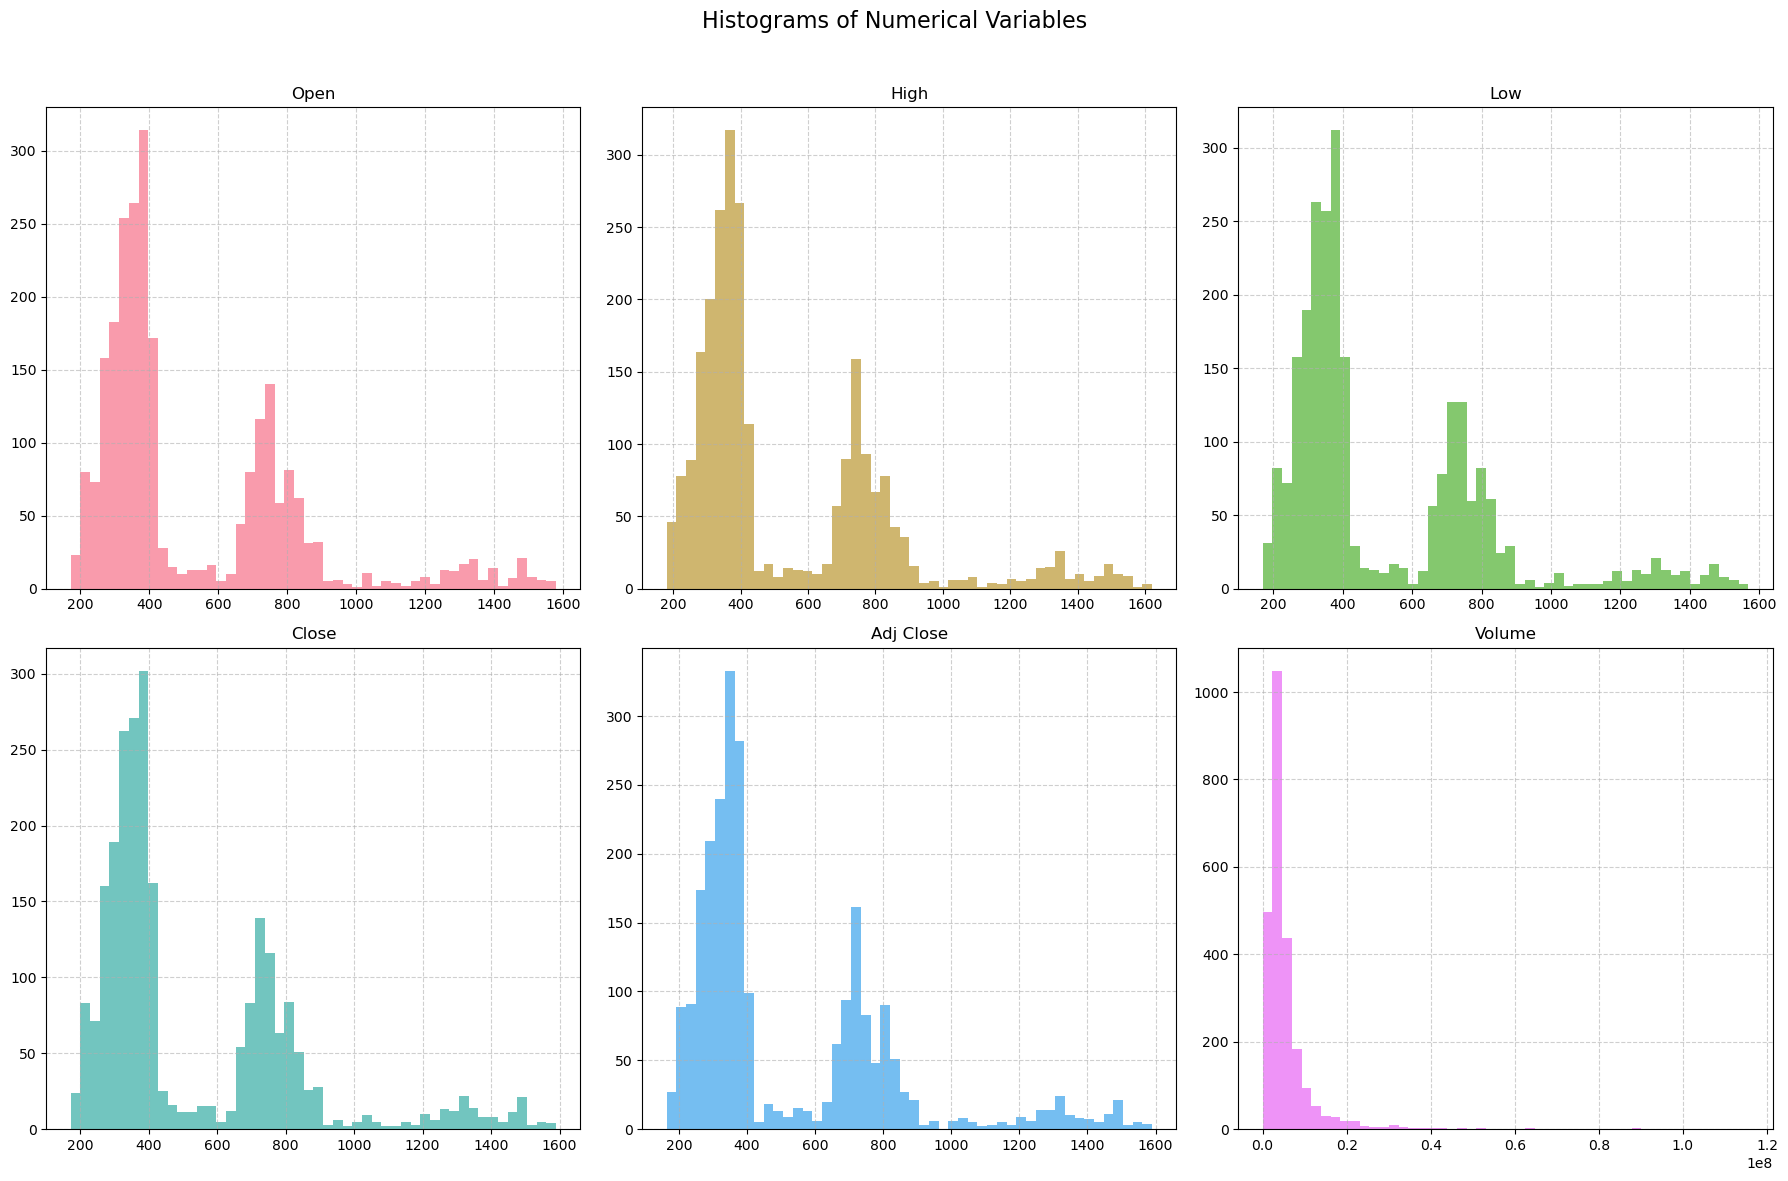

In [55]:

# Assume df is your DataFrame
numerical_vars = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Using a seaborn color palette
colors = sns.color_palette('husl', len(numerical_vars))

# Create histograms with customized colors and transparency
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(numerical_vars):
    df[var].hist(ax=axes[i], bins=50, color=colors[i], alpha=0.7)
    axes[i].set_title(var)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Histograms of Numerical Variables', size=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [56]:
# Define the height and width for each subplot
subplot_height = 300  # Height of each subplot
subplot_width = 800   # Width of the entire figure

# Create subplots with the specified height and width
fig = make_subplots(
    rows=len(numerical_vars), 
    cols=1, 
    subplot_titles=numerical_vars, 
    shared_xaxes=True, 
    vertical_spacing=0.05
)

# Iterate over each subplot and add a line plot
for i, col in enumerate(numerical_vars):
    fig.add_trace(
        go.Scatter(
            x=df['Date'], 
            y=df[col], 
            mode='lines', 
            name=col,
            line=dict(width=2)  # Customize line width
        ), 
        row=i+1, col=1
    )

# Update layout with title and theme
fig.update_layout(
    title='Stock Prices Over Time',
    showlegend=False,
    height=subplot_height * len(numerical_vars),  # Total height of the figure
    width=subplot_width,  # Width of the figure
    template='plotly',  # Light theme
    margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins
    title_x=0.5  # Center the title
)

# Update x-axis and y-axis titles for each subplot
for i in range(len(numerical_vars)):
    fig.update_xaxes(title_text='Date', row=i+1, col=1)
    fig.update_yaxes(title_text='Value', row=i+1, col=1)

# Additional customization for aesthetics
fig.update_layout(
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0, 0, 0, 0.2)'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='rgba(0, 0, 0, 0.2)'),
    font=dict(size=12, color='black')  # Adjust font size and color
)

# Show the plot
fig.show()

In [57]:
# Create the line plot using Plotly Express
fig = px.line(df, x='Date', y=numerical_vars, title='Stock Prices Over Time', 
              labels={'value': 'Stock Price', 'variable': 'Stock'})

# Customize the appearance
fig.update_layout(
    template='plotly_dark',  # Apply a dark theme
    title_x=0.5,  # Center the title
    margin=dict(l=40, r=40, t=60, b=40),  # Adjust margins
    font=dict(size=12, color='white'),  # Customize font size and color
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='rgba(255, 255, 255, 0.2)'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='rgba(255, 255, 255, 0.2)'),
    legend_title_text='Stock'  # Add legend title
)

# Show the plot
fig.show()

In [58]:
# select columns
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2014-08-21,296.899994
1,2014-08-22,297.700012
2,2014-08-25,293.350006
3,2014-08-26,298.000000
4,2014-08-27,288.250000


In [59]:
# stationarity check on data

def adf_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("Fail to reject the null hypothesis. Data is not stationary")

adf_test(df['Close'])

ADF Statistic: 1.257350
p-value: 0.996359
Fail to reject the null hypothesis. Data is not stationary


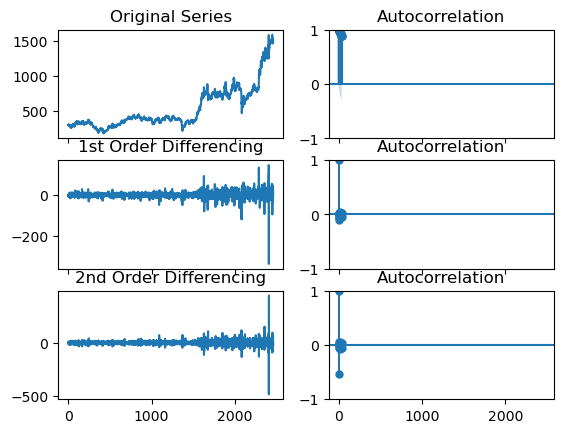

In [60]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['Close']); axes[0, 0].set_title('Original Series')
plot_acf(df['Close'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['Close'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Close'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['Close'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Close'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

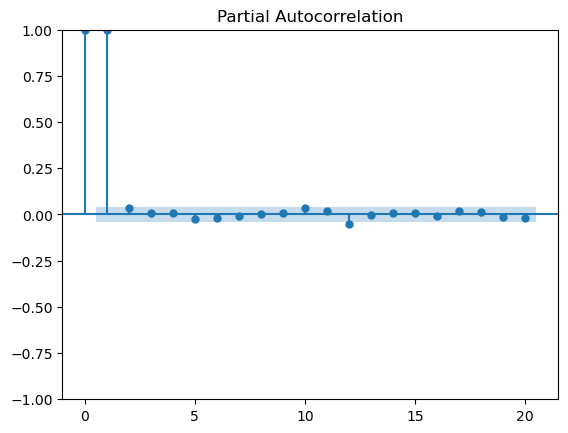

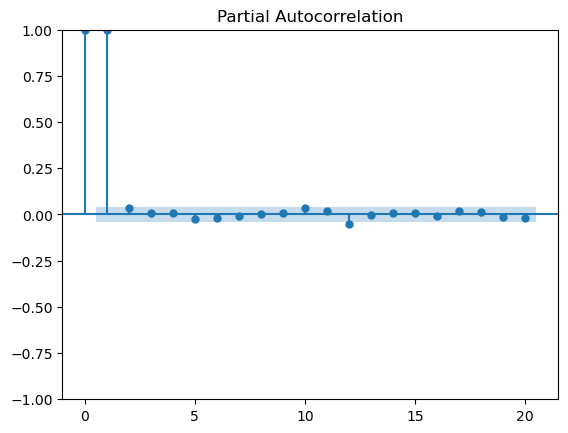

In [61]:
# partial autocorrelation
from statsmodels.tsa.stattools import acf, pacf
plot_pacf(df['Close'], lags=20, alpha=0.05)

In [62]:
# let's run SARIMA
import statsmodels.api as sm
import warnings

p , d, q = 2, 2, 2

model = sm.tsa.statespace.SARIMAX(df['Close'],
                                  order=(p, d, q),
                                  seasonal_order=(p, d, q, 12))
model = model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 2462
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood              -10575.818
Date:                            Wed, 21 Aug 2024   AIC                          21169.635
Time:                                    13:58:03   BIC                          21221.818
Sample:                                         0   HQIC                         21188.605
                                           - 2462                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0475      0.009   -117.594      0.000      -1.065      -1.030
ar.L2         -0.1330      0.008   

In [66]:
# Generate forecast
df['forecast'] = model.predict(start=df.index[-1]-60, end=df.index[-1], dynamic=True)

# Create the plot
fig = go.Figure()

# Add actual data trace
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Actual', line=dict(color='rgb(255, 111, 97)')))

# Add forecast data trace
fig.add_trace(go.Scatter(x=df.index, y=df['forecast'], mode='lines', name='Forecast', line=dict(color='rgb(107, 91, 149)')))

# Update layout with desi-inspired style
fig.update_layout(
    title='Google Closing Price Forecast',
    xaxis_title='Date',
    yaxis_title='Close Price',
    font=dict(family="Arial", size=14, color="rgb(255, 255, 255)"),
    plot_bgcolor='rgb(30, 30, 30)',
    paper_bgcolor='rgb(30, 30, 30)',
    legend=dict(font=dict(size=12, color="rgb(255, 255, 255)")),
    hovermode="x"
)

# Show plot
fig.show()


In [70]:
df.tail(62)

,Date,Close,forecast
2400,2024-05-22,1378.199951,NaN
2401,2024-05-23,1443.349976,1346.928758
2402,2024-05-24,1416.099976,1351.025447
2403,2024-05-27,1431.650024,1350.116408
2404,2024-05-28,1400.500000,1353.757706
...,...,...,...
2457,2024-08-13,1483.449951,1501.756658
2458,2024-08-14,1461.949951,1499.726551
2459,2024-08-16,1493.449951,1532.839499
2460,2024-08-19,1496.449951,1521.929635


In [71]:
residuals=df.VWAP-df_valid.forecast

AttributeError: 'DataFrame' object has no attribute 'VWAP'